#### Imports and env creation

In [1]:
# from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.constants import IDX_TO_OBJECT, OBJECT_TO_IDX

from minigrid.core.actions import Actions
from dataclasses import dataclass, field 
from typing import Set
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=5,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"
    # MiniGridEnv._gen_grid
    
    def _gen_grid(self, width, height):
      self.grid = Grid(width, height)
      self.grid.wall_rect(0, 0, width, height)

      if self.agent_start_pos is not None:
          self.agent_pos = self.agent_start_pos
          self.agent_dir = self.agent_start_dir
      else:
          self.place_agent()
      self.valid_actions = {Actions.left, Actions.right, Actions.forward}
    
      
      self.put_obj(Goal(), width - 2, height - 2)

    #   for i in range(0, height):
    #     self.grid.set(5, i, Wall())

    #   self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
    #   self.grid.set(3, 6, Key(COLOR_NAMES[0]))
    
    def get_array_repr(self, with_agent=True):
        grid_array = self.unwrapped.grid.encode()[:,:,0]
        # print(grid_array)
        # print(self.agent_pos)
        grid_array[self.agent_pos[0],self.agent_pos[1]]=OBJECT_TO_IDX['agent']
        return grid_array.T
    

# env = SimpleEnv(render_mode="human")
# manual_control = ManualControl(env, seed=42)

env = SimpleEnv()
env.reset()
print(env.get_array_repr())

# enable manual control for testing
# manual_control.start()

map_numbers = [1,2,8,10]

[[ 2  2  2  2  2]
 [ 2 10  1  1  2]
 [ 2  1  1  1  2]
 [ 2  1  1  8  2]
 [ 2  2  2  2  2]]


#### Agent motion

In [ ]:
from agents.random import RandomAgent
n_steps = 10000

random_action_agent = RandomAgent(valid_actions=env.valid_actions)

dirarr = ['Right', 'Down', 'Left','Up']
actions_to_idx = {Actions.left:0, Actions.right:1, Actions.forward:2}

image_list = []

for i in range(n_steps):
    action = random_action_agent.act()
    arr = env.get_array_repr().flatten()
    arr = np.append(arr, [actions_to_idx[action], env.agent_dir])
    image_list.append(arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)
    # print(env.get_array_repr())

print(image_list[:3])

[array([ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1, 10,  2,  2,  1,
        1,  8,  2,  2,  2,  2,  2,  2,  1,  3]), array([ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1, 10,  2,  2,  1,
        1,  8,  2,  2,  2,  2,  2,  2,  0,  0]), array([ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1, 10,  2,  2,  1,
        1,  8,  2,  2,  2,  2,  2,  2,  2,  3])]


#### Helper functions

In [4]:
import torch
from torch import nn, optim

In [5]:
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current GPU device id (e.g., 0)
print(torch.cuda.get_device_name(0))  # Displays the GPU name
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f"Using device: {device}")

2.1.1+cu121
True
0
NVIDIA GeForce MX330
Using device: cpu


In [6]:
#(Modified) Neuromatch helper funcitons
def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)
    

def runSGD(net, input_train, target_train, input_test, target_test, criterion='mse',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # 1. Define the device
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device = torch.device('cpu')
  print(f"Using device: {device}")

  # 2. Move the network to the device
  net.to(device)

  # 3. Move the main tensors to the device (crucial for initial setup)
  input_train = input_train.to(device)
  target_train = target_train.to(device)
  input_test = input_test.to(device)
  target_test = target_test.to(device)

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  elif criterion == 'cel':
    loss_fn = nn.CrossEntropyLoss() 
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Move the loss function to the device if it has parameters (CrossEntropyLoss does not, 
  # but it's good practice for others like L1Loss which might have reduction='none')
  loss_fn.to(device)

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    
    shuffle_idx = np.random.permutation(len(input_train))

    batches_input = torch.split(input_train[shuffle_idx], batch_size)
    batches_target = torch.split(target_train[shuffle_idx], batch_size)

    batches = zip(batches_input, batches_target)


    shuffle_idx = np.random.permutation(len(input_train))
    # batches = torch.split(input_train[shuffle_idx], batch_size)
    # for batch in batches:
    #   output_train = net(batch)
    #   loss = loss_fn(output_train, batch)
    for batch_input, batch_target in batches:
      batch_input = batch_input.float()
      batch_target = batch_target.float()
      output_train = net(batch_input)  # Forward pass on the input batch
      loss = loss_fn(output_train, batch_target)  # Compare output with the target
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, target_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, target_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, target_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, target_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, target_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, target_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()
  print(device)


#### Input preparation

In [63]:
# X_train, X_test = train_test_split(image_list, test_size=0.2, random_state=42)
test_size=0.2
cutoff = int((1-test_size)*len(image_list))
X_train, X_test = image_list[:cutoff], image_list[cutoff:] 

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)


def one_hot_encode_set(values, classes):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    one_hot = torch.zeros(len(classes))
    one_hot[classdict[values.item()]] = 1
    return one_hot

def continuous_class(values, classes, direct):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    val = classdict[values.item()]
    if (values.item()==10):
        val+=direct
    return torch.tensor([val])


# Define a function for one-hot encoding
def one_hot_encode(values, num_classes):
    one_hot = torch.zeros(num_classes)
    one_hot[values] = 1
    return one_hot

# Function to process the entire array (each input array of shape [length])
def process_input(input_array, mode):
    if mode == 'in':
    
        # first_part = torch.cat([one_hot_encode(input_array[i], 11) for i in range(25)])
        # first_part = torch.cat([one_hot_encode_set(input_array[i], map_numbers) for i in range(25)])
        first_part = torch.cat([continuous_class(input_array[i], map_numbers, input_array[26]) for i in range(25)])

        # 26th position: one-hot encoded into 3 classes
        second_part = one_hot_encode(input_array[25], 3)
        
        # Last position: one-hot encoded into 4 classes
        # third_part = one_hot_encode(input_array[26], 4)

        # print(torch.cat([first_part, second_part, third_part], dim=0))
        # Concatenate all parts to form the final one-hot encoded array
        return torch.cat([first_part, second_part], dim=0)
    elif mode == 'out':
        return torch.cat([continuous_class(input_array[i], map_numbers, input_array[26]) for i in range(25)])


# Apply to the whole dataset
input_orientation_train = [x[26] for x in input_train]
input_orientation_test = [x[26] for x in input_test]
target_orientation_train = [x[26] for x in target_train]
target_orientation_test = [x[26] for x in target_test]

# Apply to the whole dataset
input_train_processed = torch.stack([process_input(x, 'in') for x in input_train])
input_test_processed = torch.stack([process_input(x, 'in') for x in input_test])
target_train_processed = torch.stack([process_input(x, 'out') for x in target_train])
target_test_processed = torch.stack([process_input(x, 'out') for x in target_test])


print(target_train)
print(input_train)


tensor([[2, 2, 2,  ..., 2, 0, 0],
        [2, 2, 2,  ..., 2, 2, 3],
        [2, 2, 2,  ..., 2, 0, 3],
        ...,
        [2, 2, 2,  ..., 2, 0, 2],
        [2, 2, 2,  ..., 2, 1, 1],
        [2, 2, 2,  ..., 2, 1, 2]])
tensor([[2, 2, 2,  ..., 2, 1, 3],
        [2, 2, 2,  ..., 2, 0, 0],
        [2, 2, 2,  ..., 2, 2, 3],
        ...,
        [2, 2, 2,  ..., 2, 0, 3],
        [2, 2, 2,  ..., 2, 0, 2],
        [2, 2, 2,  ..., 2, 1, 1]])


#### Autoencoder definition

In [64]:
encoding_size=20
input_size=input_train_processed.size(1)
output_size = target_train_processed.size(1)
model = nn.Sequential(
    nn.Linear(input_size, int(input_size * 15)),
    nn.ReLU(),
    nn.Linear(int(input_size * 15), encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, int(output_size * 15)),
    nn.ReLU(),
    nn.Linear(int(output_size *15), output_size),
    )

# model[:-2].apply(init_weights_kaiming_normal)

n_l = 4
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=28, out_features=420, bias=True)
  (1): ReLU()
  (2): Linear(in_features=420, out_features=20, bias=True)
  (3): ReLU()
)

Decoder 

 Sequential(
  (4): Linear(in_features=20, out_features=375, bias=True)
  (5): ReLU()
  (6): Linear(in_features=375, out_features=25, bias=True)
)


#### Autoencoder training

Using device: cpu
Epoch 	 Loss train 	 Loss test
1/10	 0.1896		 0.1923
2/10	 0.1413		 0.1444
3/10	 0.0972		 0.0985
4/10	 0.0642		 0.0685
5/10	 0.0368		 0.0405
6/10	 0.0256		 0.0278
7/10	 0.0137		 0.0156
8/10	 0.0083		 0.0099
9/10	 0.0043		 0.0054
10/10	 0.0130		 0.0153


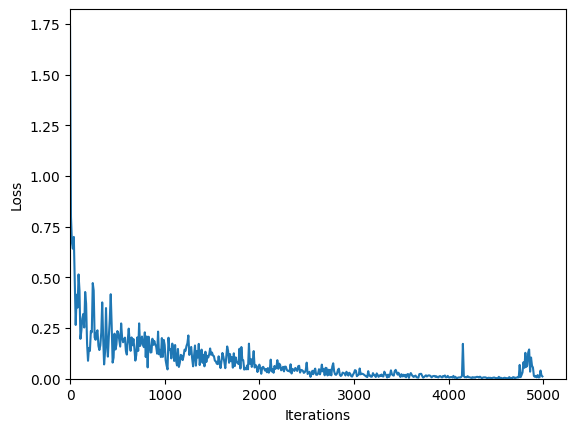

cpu


In [65]:
n_epochs = 10
batch_size = 16

runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size)

In [66]:
input_test_processed = input_test_processed.to(device)
output = model(input_test_processed)  # Model output (logits or probabilities)
# torch.set_printoptions(profile="full")
# print(output)
output = output.cpu() 
# Initialize a list to hold the decoded outputs for each observation
decoded_outputs = []

incorrect_agent_num=0
incorrect_orientation=0
incorrect_cell=0

for i in range(output.size(0)):  # Loop over each sample in the batch
    # Extract the blocks of the output
    first_25 = output[i]
    # second_block = output[i, input_train_processed.size(1)-7:input_train_processed.size(1)-4]    # Next block of size 3
    # third_block = output[i, input_train_processed.size(1)-7:]             # Last block of size 4

    # Decode each block by taking the argmax (index of max value)
    decoded_first_25 = torch.round(first_25).long()  # 25 values, each between 0-10
    # decoded_second = torch.argmax(second_block)       # Single value between 0-2
    # decoded_third = torch.argmax(third_block)         # Single value between 0-3
    
    map_array = map_numbers+[11,12,13]
    in_map_array = torch.isin(decoded_first_25, torch.tensor(range(len(map_array))))
    # Convert values not in map_array to len(map_array)
    adjusted_values = torch.where(in_map_array, decoded_first_25, torch.tensor(len(map_array)))
    mapping = torch.tensor(map_array+[-1])
    decoded_first_25 = mapping[adjusted_values]

    num_agents = 0

    for j, val in enumerate(decoded_first_25):
        if val >= 10 and num_agents == 0:
            decoded_second = val -10
        if val>= 10:
            num_agents +=1
        if (target_test[i, j] != val and (val < 10 or target_test[i, j] < 10)):
            print("cell", i)
            incorrect_cell +=1
    
    decoded_first_25[decoded_first_25 > 10] = 10

    if num_agents != 1:
        decoded_second = torch.tensor(-1, dtype=torch.long)
        incorrect_agent_num +=1
    
    if (decoded_second != target_orientation_test[i]):
        incorrect_orientation +=1

    # Use torch.masked_select to get all matching values
    matches = torch.masked_select(decoded_first_25, decoded_first_25 >= 10)

    # Ensure it's a 1D tensor for concatenation
    decoded_second = decoded_second.unsqueeze(0)

    # Combine the decoded values into a single list for this observation
    decoded_sample = torch.cat([decoded_first_25, decoded_second])
    
    # Append the decoded sample to the final list
    decoded_outputs.append(decoded_sample)

acc_cell = 1.0-(incorrect_cell/(25*output.size(0)))
acc_orientation = 1.0-(incorrect_orientation/output.size(0))
acc_agentnum = 1.0-(incorrect_agent_num/output.size(0))

# Convert to tensor if needed
decoded_outputs = torch.stack(decoded_outputs)
print(decoded_outputs)

print ("Cell accuracy:", acc_cell)
print ("Agent orientation accuracy:", acc_orientation)
print ("Number of agents accuracy:", acc_agentnum)

cell 18
cell 35
cell 40
cell 43
cell 97
cell 152
cell 206
cell 206
cell 229
cell 241
cell 241
cell 245
cell 268
cell 276
cell 281
cell 282
cell 305
cell 317
cell 325
cell 329
cell 332
cell 333
cell 359
cell 378
cell 399
cell 414
cell 432
cell 453
cell 460
cell 466
cell 466
cell 524
cell 555
cell 569
cell 593
cell 608
cell 614
cell 618
cell 623
cell 636
cell 654
cell 654
cell 672
cell 681
cell 682
cell 700
cell 700
cell 762
cell 799
cell 810
cell 867
cell 891
cell 897
cell 975
cell 975
cell 997
cell 997
cell 1001
cell 1011
cell 1026
cell 1032
cell 1033
cell 1135
cell 1145
cell 1195
cell 1204
cell 1210
cell 1248
cell 1300
cell 1300
cell 1341
cell 1341
cell 1362
cell 1418
cell 1433
cell 1452
cell 1492
cell 1497
cell 1498
cell 1570
cell 1570
cell 1572
cell 1591
cell 1591
cell 1606
cell 1631
cell 1644
cell 1645
cell 1669
cell 1687
cell 1739
cell 1774
cell 1776
cell 1804
cell 1804
cell 1815
cell 1829
cell 1831
cell 1835
cell 1836
cell 1842
cell 1857
cell 1869
cell 1888
cell 1904
cell 1904
ce

In [67]:
for i in range(min(30,decoded_outputs.size(0))):
    # Print the input, decoded grid, and target test grid side by side
    print(f"Sample {i + 1}:")
    
    # Input grid (first 25 values reshaped into 5x5)
    print("Input Grid:")
    print(input_test[i, :25].reshape(5, 5).int())
    
    # Decoded grid (first 25 values reshaped into 5x5)
    print("Decoded Grid:")
    print(decoded_outputs[i, :25].reshape(5, 5).int())
    
    # Target test grid (first 25 values reshaped into 5x5)
    print("Target Grid:")
    print(target_test[i, :25].reshape(5, 5).int())
    
    # Action and Orientation for input, decoded, and target test
    print(f"Input Action: {input_test[i, 25].item()}")
    print(f"Decoded Orientation: {decoded_outputs[i, 25].item()} | Target Orientation: {target_orientation_test[i].item()} | Input Orientation: {input_orientation_test[i].item()}")
    
    print("=" * 50)  # Separator


Sample 1:
Input Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Target Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Input Action: 0
Decoded Orientation: 2 | Target Orientation: 2 | Input Orientation: 3
Sample 2:
Input Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2]]